Before you go through this, you might want to have a look at the wiki entry for the
[Phase Encoding Analysis tool](https://github.com/ccnmaastricht/CNI_toolbox/wiki/Phase-Encoding-Analysis-(Python)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cni_tlbx import PEA

from src.model import V1Model
from src.utils import create_stimulus

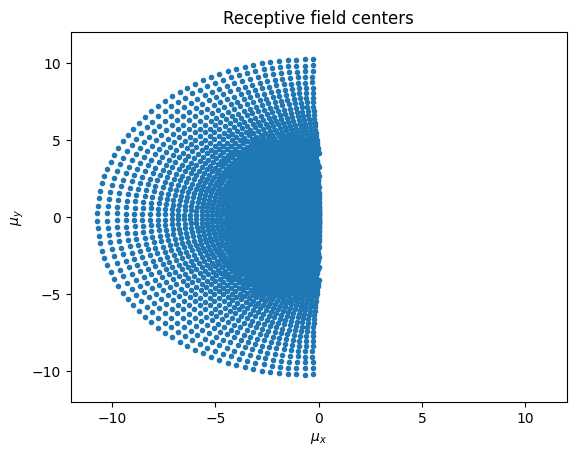

In [6]:
# stimulus parameters
center = (-4.95, 4.95)  # center of the stimulus
stimulus_resolution = 100
stimulus_parameters = {
    'center': center,
    'width': 0.17,
    'steps': 18,        # measured in TRs
    'repetitions': 8,
    'pre_rest': 4,      # measured in TRs
    'post_rest': 4,     # measured in TRs
}

# define visual field coordinates for stimulation (upper left quadrant)
r = np.linspace(-12, 0, stimulus_resolution)
X, Y = np.meshgrid(r, r)
X = X.flatten()
Y = -Y.flatten()

# create stimulus (feel free to improve this function in utils.py based on your actual experiment)
stimulus = create_stimulus(X, Y, stimulus_parameters)

# define V1 model (right hemisphere) and compute Gaussian receptive fields for each voxel
model = V1Model()
model.compute_rf(X, Y)

# compute hemodynamic response
hemodynamic_response = model.compute_response(stimulus)

# add noise to hemodynamic response (i.i.d. Gaussian noise with zero mean and 0.1 standard deviation; feel free to change this to something more realistic)
hemodynamic_response += np.random.normal(0, 0.1, hemodynamic_response.shape)

# show receptive field centers (left hemifield)
plt.plot(model.mu_x, model.mu_y, '.')
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.xlabel('$\\mu_x$')
plt.ylabel('$\\mu_y$')
plt.title('Receptive field centers');

In [3]:
# transpose hemodynamic response (PEA expects time x voxels)
hemodynamic_response = hemodynamic_response.transpose()

# remove rest periods from hemodynamic response
hemodynamic_response = hemodynamic_response[stimulus_parameters['pre_rest']:-stimulus_parameters['post_rest']]

In [4]:
# Phase-encoding analysis
hemodynamic_delay = 4   # in seconds; accounts for hemodynamic delay
threshold = -np.inf     # needed because tool assumes fMRI data with high mean intensity values (anything below 100 is usually removed) but simulated data exhibits much lower values.
n_samples, n_voxels = hemodynamic_response.shape
stimulation_frequency = (stimulus_parameters['steps'] * 2.5) ** -1
analysis_parameters = {'f_sampling': 1 / 2.5,
        'f_stim': stimulation_frequency,
        'n_samples': n_samples,
        'n_rows': n_voxels,
        'n_cols': 1,
        'n_slices': 1}

pea = PEA(analysis_parameters)

pea.set_delay(hemodynamic_delay)
pea.set_direction('ccw')
results = pea.fitting(hemodynamic_response, threshold = threshold)


performing analysis
[====================] 100%

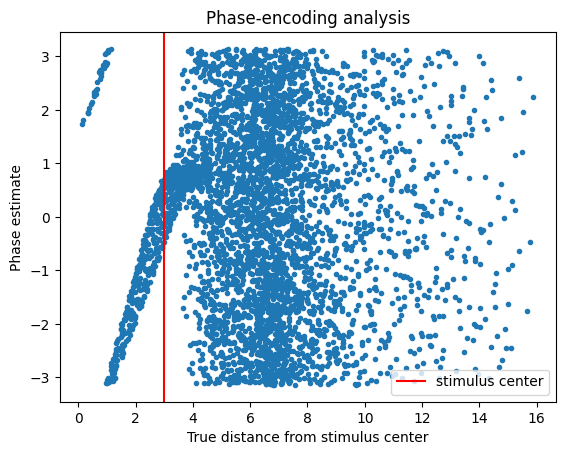

In [5]:
# evaluate results

# compute true distances of model receptive field centers from center of the stimulus
true_distances = np.sqrt((model.mu_x - center[0]) ** 2 + (model.mu_y - center[1]) ** 2)

# plot phase estimates against true distances. Add red line at a distance of 3 froms stimulus center.
plt.plot(true_distances, results['phase'], '.')
plt.axvline(3, color='r', label='stimulus center')
plt.xlabel('True distance from stimulus center')
plt.ylabel('Phase estimate')
plt.legend()
plt.title('Phase-encoding analysis');
